In [14]:
import deepchem as dc
import os
import sys
os.environ['DGLBACKEND'] = 'pytorch'
import numpy as np
import pandas as pd
import dgl
import torch
from deepchem.feat.graph_data import GraphData
from deepchem.models import MPNNModel

import math

import copy
sys.path.append('../')
from utils import *
from save_data import *
from run_experiments import run_experiments
import matplotlib.pyplot as plt
from itertools import product
from IPython.display import display, HTML
display(HTML("<style>.jp-OutputArea-output {display:flex}</style>"))

In [5]:
freesolv = pd.read_csv('../expt_phys_data/full_dataset_hilo_with_val.csv')

In [50]:
folder_list = json.load(open('../mpnn_custom_feat/prelim_hilo_test_results/folder_list.json'))['folder_list']
 
# print(folder_list)
phys_models = ['tip3p','null']
dataset_names = ['test','train']
folder_list

['prelim_hilo_test_results/feats-node_c-gb-sgb-br-z-ic-hy-hb-ar-de-nh-edge_r-gb-bt-sr-co-sc-edges-var_bonds-implicit_h_True/ep_200-over_0_4-opat_20-del_0_01-cpat_20/',
 'prelim_hilo_test_results/feats-node_c-gb-sgb-br-z-ic-hy-hb-ar-de-nh-edge_r-gb-bt-sr-co-sc-edges-var_bonds-implicit_h_False/ep_200-over_0_4-opat_20-del_0_01-cpat_20/',
 'prelim_hilo_test_results/feats-node_c-gb-sgb-br-z-ic-hy-hb-ar-de-nh-edge_r-gb-bt-sr-co-sc-edges-var_fc-implicit_h_True/ep_200-over_0_4-opat_20-del_0_01-cpat_20/',
 'prelim_hilo_test_results/feats-node_c-gb-sgb-br-z-ic-hy-hb-ar-de-nh-edge_r-gb-bt-sr-co-sc-edges-var_fc-implicit_h_False/ep_200-over_0_4-opat_20-del_0_01-cpat_20/',
 'prelim_hilo_test_results/feats-node_z-ic-hy-hb-ar-de-nh-edge_bt-sr-co-sc-edges-var_bonds-implicit_h_True/ep_200-over_0_4-opat_20-del_0_01-cpat_20/',
 'prelim_hilo_test_results/feats-node_z-ic-hy-hb-ar-de-nh-edge_bt-sr-co-sc-edges-var_bonds-implicit_h_False/ep_200-over_0_4-opat_20-del_0_01-cpat_20/',
 'prelim_hilo_test_results/fe

In [10]:
def get_top_n(df,n):
    df2 = df.sort_values(by='expt')
    df2 = df2[:n]
    df2.sort_index(inplace=True)
    return df2
    
def get_above_n(df,n):
    df2 = df[(df.expt > n)]
    return df2

In [71]:
N = [80,40,20,10]
for target in phys_models:
    folder = '../../Old_DC_solvation/high_low_split_results/'+target+'/'
    name = get_physics_model_name(target)
    print(name)
    df = pd.read_csv(folder+'train'+'.csv')
    expt = df['expt']
    phys = df['physics']
    ml = df['means']
    rmse_ml=np.round(rmsd(expt,ml),2)
    rmse_phys=np.round(rmsd(expt,phys),2)
    if(target == 'null'):
        means = phys + (-7.7)#freesolv.expt.mean()
        print(f'train{df.expt.min()} mean = {df.expt.mean():.2f}: null: {rmse_phys}, means: {rmsd(expt,means):.2f}, physics + ml: {rmse_ml}')
    else:
        print(f'train, mean = {df.expt.mean():.2f}: physics: {rmse_phys}, physics + ml: {rmse_ml}')
    # print(f'train: physics: {rmse_phys}, physics + ml: {rmse_ml}')
    for n in N:
        df = pd.read_csv(folder+'test'+'.csv')
        df = get_top_n(df,n)
        
        expt = df['expt']
        phys = df['physics']
        ml = df['means']
        
        rmse_ml=np.round(rmsd(expt,ml),2)
        rmse_phys=np.round(rmsd(expt,phys),2)
        if(target == 'null'):
            means = phys + (-7.7)#freesolv.expt.mean()
            print(f'n = {n}, cuttoff = {df.expt.max()}, mean = {df.expt.mean():.2f}: null: {rmse_phys}, means: {rmsd(expt,means):.2f}, physics + ml: {rmse_ml}')
        else:
            print(f'n = {n}, cuttoff = {df.expt.max()}, mean = {df.expt.mean():.2f}: physics: {rmse_phys}, physics + ml: {rmse_ml}')

TIP3P
train, mean = -2.79: physics: 1.36, physics + ml: 0.51
n = 80, cuttoff = -7.77, mean = -10.92: physics: 2.47, physics + ml: 1.87
n = 40, cuttoff = -9.63, mean = -12.96: physics: 2.87, physics + ml: 2.21
n = 20, cuttoff = -11.01, mean = -15.87: physics: 3.26, physics + ml: 2.71
n = 10, cuttoff = -15.83, mean = -19.15: physics: 3.77, physics + ml: 3.4
ML alone
train-7.67 mean = -2.79: null: 3.82, means: 5.56, physics + ml: 0.63
n = 80, cuttoff = -7.77, mean = -10.92: null: 11.49, means: 4.80, physics + ml: 6.06
n = 40, cuttoff = -9.63, mean = -12.96: null: 13.59, means: 6.66, physics + ml: 7.92
n = 20, cuttoff = -11.01, mean = -15.87: null: 16.37, means: 9.11, physics + ml: 10.38
n = 10, cuttoff = -15.83, mean = -19.15: null: 19.38, means: 11.83, physics + ml: 13.07


In [58]:
def get_means(folder,dataset_name):
    dirs = [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d)) and not d.startswith('.')]
    # dataset_names = [d for d in os.listdir(folder+dirs[0]+'/') if os.path.isfile(os.path.join(folder+dirs[0]+'/', d)) and d.endswith('.csv') and not d.startswith('convergence')]
    df = pd.read_csv(folder+dirs[0]+'/'+dataset_name)
    array = np.zeros((len(df),len(dirs)))
    for j in range(len(dirs)):
        df = pd.read_csv(folder+dirs[j]+'/'+dataset_name)
        array[:,j] = df.physics_ml
    mean_array = np.mean(array,axis=1)
    return mean_array


In [70]:
N = [80,40,20,10]

for i in range(3,5):
    print(folder_list[i])
    for target in phys_models:
        folder = '../mpnn_custom_feat/'+folder_list[i]+target+'/'
        name = get_physics_model_name(target)
        print(name)
    
        df = pd.read_csv(folder+'model0/train'+'.csv')
        df['ML'] = get_means(folder,'train.csv')
        expt = df['expt']
        phys = df['physics']
        ml = df['ML']

        rmse_ml=np.round(rmsd(expt,ml),2)
        rmse_phys=np.round(rmsd(expt,phys),2)
        if(target == 'null'):
            means = phys + freesolv.expt.mean()
            print(f'train, mean = {df.expt.mean():.2f}: null: {rmse_phys}, means: {rmsd(expt,means):.2f}, physics + ml: {rmse_ml}')
        else:
            print(f'train, mean = {df.expt.mean():.2f}: physics: {rmse_phys}, physics + ml: {rmse_ml}')
        # print(f'train: physics: {rmse_phys}, physics + ml: {rmse_ml}')
        for n in N:
            df = pd.read_csv(folder+'model0/test'+'.csv')
            df['ML'] = get_means(folder,'test.csv')
            df = get_top_n(df,n)
            
            expt = df['expt']
            phys = df['physics']
            ml = df['ML']
            
            rmse_ml=np.round(rmsd(expt,ml),2)
            rmse_phys=np.round(rmsd(expt,phys),2)
            if(target == 'null'):
                means = phys + (-7.7)#freesolv.expt.mean()
                print(f'n = {n}, cuttoff = {df.expt.max()}, mean = {df.expt.mean():.2f}: null: {rmse_phys}, means: {rmsd(expt,means):.2f}, physics + ml: {rmse_ml}')
            else:
                print(f'n = {n}, cuttoff = {df.expt.max()}, mean = {df.expt.mean():.2f}: physics: {rmse_phys}, physics + ml: {rmse_ml}')
        print()
            

prelim_hilo_test_results/feats-node_c-gb-sgb-br-z-ic-hy-hb-ar-de-nh-edge_r-gb-bt-sr-co-sc-edges-var_fc-implicit_h_False/ep_200-over_0_4-opat_20-del_0_01-cpat_20/
TIP3P
train, mean = -2.79: physics: 1.37, physics + ml: 0.48
n = 80, cuttoff = -7.77, mean = -10.92: physics: 2.47, physics + ml: 2.56
n = 40, cuttoff = -9.63, mean = -12.96: physics: 2.87, physics + ml: 3.12
n = 20, cuttoff = -11.01, mean = -15.87: physics: 3.26, physics + ml: 3.71
n = 10, cuttoff = -15.83, mean = -19.15: physics: 3.77, physics + ml: 4.75

ML alone
train, mean = -2.79: null: 3.83, means: 2.81, physics + ml: 0.39
n = 80, cuttoff = -7.77, mean = -10.92: null: 11.49, means: 4.80, physics + ml: 5.68
n = 40, cuttoff = -9.63, mean = -12.96: null: 13.59, means: 6.66, physics + ml: 7.53
n = 20, cuttoff = -11.01, mean = -15.87: null: 16.37, means: 9.11, physics + ml: 9.94
n = 10, cuttoff = -15.83, mean = -19.15: null: 19.38, means: 11.83, physics + ml: 12.65

prelim_hilo_test_results/feats-node_z-ic-hy-hb-ar-de-nh-edg

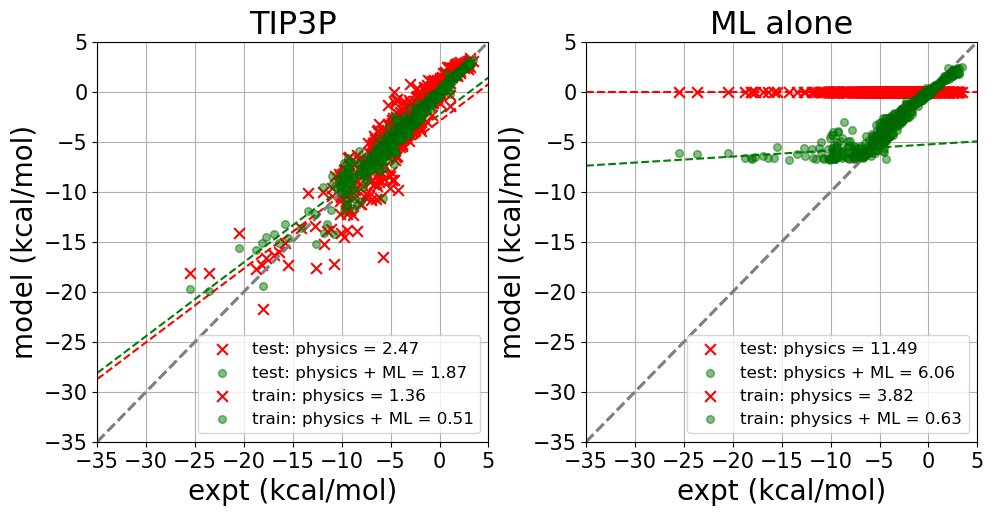

In [32]:
dataset_names = ['test','train']
i=0
plt.figure(figsize=(11,5),linewidth=5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.3, wspace=0.25)
fs = 15
h = 5
f = -35
for target in phys_models:
    plt.subplot(1,2, i+1)
    i+=1
    folder = '../../Old_DC_solvation/high_low_split_results/'+target+'/'
    name = get_physics_model_name(target)
    for dataset_name in dataset_names:
        df = pd.read_csv(folder+dataset_name+'.csv')
        # df2 = get_top_n(df,40)
        expt = df['expt']
        phys = df['physics']
        ml = df['means']
        
        rmse_ml=np.round(rmsd(expt,ml),2)
        rmse_phys=np.round(rmsd(expt,phys),2)
        plt.title(name,fontsize=fs+8)
        plt.grid(True)
        plt.xlim([f,h])
        plt.ylim([f,h])
        plt.scatter(expt,phys, label = dataset_name+': physics = '+str(rmse_phys),color='red',zorder=2,s=60,marker='x')
        plt.scatter(expt,ml, label = dataset_name+": physics + ML = "+str(rmse_ml),color='green',edgecolors='darkgreen',zorder=3,s=30,alpha=0.5)
        plt.legend(loc='lower right',fontsize = fs-3)
        # plt.scatter(expt,phys,zorder=2,s=25,alpha=0.4,color='red')
        z_p = np.polyfit(expt, phys, 1)
        p_p = np.poly1d(z_p)
        z_ml = np.polyfit(expt, ml, 1)
        p_ml = np.poly1d(z_ml)
        x_range = np.linspace(f, h, 100)
        if(dataset_name == 'test'):
            plt.plot(x_range,p_p(x_range),"r--")
            plt.plot(x_range,p_ml(x_range),"g--")
        plt.axline((0,0),slope=1,color='gray',linewidth=2,linestyle='dashed')
        # plt.legend(loc='lower right')
        plt.xlabel("expt (kcal/mol)",fontsize=fs+5.)
        plt.ylabel("model (kcal/mol)",fontsize=fs+5.)
        plt.xticks(fontsize=fs)
        plt.yticks(fontsize=fs)

In [8]:
freesolv.sort_values(by='expt')[:2]

,id,smiles,iupac name,expt,tip3p,cha,zap9,mbondi,asc,igb5,null,train,train_val_test
616,mobley_9534740,C([C@@H]1[C@H]([C@@H]([C@H]([C@@H](O1)O)O)O)O)O,"(2R,3R,4S,5S,6R)-6-(hydroxymethyl)tetrahydropy...",-25.47,-18.095,-15.6033,-18.0083,-25.7379,-18.104,-17.106,0,True,2
282,mobley_4587267,C([C@H]([C@H]([C@@H]([C@@H](CO)O)O)O)O)O,"(2R,3R,4R,5R)-Hexan-1,2,3,4,5,6-hexol",-23.62,-18.162,-20.4906,-22.5047,-31.9107,-22.823,-22.502,0,True,2
